In [1]:
#!pip install pandas_datareader

In [2]:
import numpy as np
import pandas as pd
import os
import pandas_datareader as web

In [3]:
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [4]:
from stldecompose import decompose
import statsmodels.api as sm


In [5]:
# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [6]:
# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

In [7]:
# Show charts when running kernel
init_notebook_mode(connected=True)

In [8]:
# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,1,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [9]:
df = web.DataReader('FXE',data_source='yahoo',start='2010-01-01',end='2020-09-26')
df.head()

High         Low        Open       Close    Volume  \
Date                                                                   
2009-12-31  143.639999  142.869995  143.600006  142.910004  169200.0   
2010-01-04  144.320007  143.809998  144.130005  143.860001  344000.0   
2010-01-05  144.089996  143.250000  143.889999  143.460007  675600.0   
2010-01-06  144.080002  143.190002  143.279999  143.889999  244700.0   
2010-01-07  143.259995  142.820007  143.190002  142.970001  524900.0   

             Adj Close  
Date                    
2009-12-31  142.596252  
2010-01-04  143.544159  
2010-01-05  143.145035  
2010-01-06  143.574097  
2010-01-07  142.656097

In [10]:
#df = df.iloc[::-1]
df.index.name = 'Date'
df.reset_index(inplace=True)
df.head()

Date        High         Low        Open       Close    Volume  \
0 2009-12-31  143.639999  142.869995  143.600006  142.910004  169200.0   
1 2010-01-04  144.320007  143.809998  144.130005  143.860001  344000.0   
2 2010-01-05  144.089996  143.250000  143.889999  143.460007  675600.0   
3 2010-01-06  144.080002  143.190002  143.279999  143.889999  244700.0   
4 2010-01-07  143.259995  142.820007  143.190002  142.970001  524900.0   

    Adj Close  
0  142.596252  
1  143.544159  
2  143.145035  
3  143.574097  
4  142.656097

In [11]:
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Candlestick(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

#fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

In [12]:
#df_close = df[['Date', 'Close']].copy()
#df_close = df_close.set_index('Date')
#df_close.head()

In [13]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

In [14]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

In [15]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

In [16]:
df.loc[:,'tClose'] = df.loc[:,'Close']

In [17]:
df['Close'] = df['Close'].shift(-1)

In [18]:

df = df.iloc[33:] # Because of moving averages and MACD line
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))
df.head()

Date        High         Low        Open       Close     Volume  \
0 2010-02-19  135.800003  134.570007  134.889999  135.699997  3046400.0   
1 2010-02-22  136.000000  135.460007  135.899994  134.750000   669200.0   
2 2010-02-23  135.509995  134.699997  135.259995  135.050003   713200.0   
3 2010-02-24  135.960007  134.880005  135.199997  135.270004   735600.0   
4 2010-02-25  135.419998  134.380005  134.449997  135.850006   936800.0   

    Adj Close       EMA_9       SMA_5      SMA_10      SMA_15      SMA_30  \
0  135.352173  137.895415  136.310001  136.606000  137.403335  140.057334   
1  135.402100  137.664449  136.122000  136.454999  137.149334  139.782667   
2  134.454163  137.462960  136.088000  136.384999  136.970000  139.540334   
3  134.753494  137.185411  135.556000  136.223000  136.683333  139.235000   
4  134.973022  136.967451  135.401999  135.975999  136.394667  138.905333   

         RSI      MACD  MACD_signal      tClose  
0  36.542264 -1.285781    -1.269469  135.649994  
1  32.497425 -1.274369    -1.270567  135.699997  
2  27.281698 -1.322209    -1.281866  134.750000  
3  31.364615 -1.321768    -1.290435  135.050003  
4  38.869309 -1.289545    -1.290247  135.270004

In [19]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

In [20]:
drop_cols = ['Date', 'Open', 'Volume', 'Low', 'High', 'Adj Close']


train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

In [21]:
y_train = train_df['Close'].copy()
X_train = train_df.drop(['Close'], 1)

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(['Close'], 1)

y_test  = test_df['Close'].copy()
X_test  = test_df.drop(['Close'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1869 entries, 0 to 1868
Data columns (total 9 columns):
EMA_9          1869 non-null float64
SMA_5          1869 non-null float64
SMA_10         1869 non-null float64
SMA_15         1869 non-null float64
SMA_30         1869 non-null float64
RSI            1869 non-null float64
MACD           1869 non-null float64
MACD_signal    1869 non-null float64
tClose         1869 non-null float64
dtypes: float64(9)
memory usage: 131.5 KB


In [22]:
%%time

parameters = {
    'n_estimators': [800],
    'learning_rate': [0.01],
    'max_depth': [25],
    'gamma': [ 0.01],
    'random_state': [20],
    'min_child_weight':[6],
    'subsample':[0.1]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

#print(f'Best params: {clf.best_params_}')
#print(f'Best validation score = {clf.best_score_}')

[15:16:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:16:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:16:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameter

In [23]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: user 3.56 s, sys: 49.1 ms, total: 3.6 s
Wall time: 485 ms


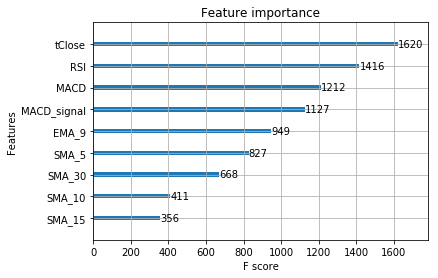

In [24]:
plot_importance(model);

In [25]:
y_pred = model.predict(X_test)
#print(f'y_true = {np.array(y_test)[:5]}')
#print(f'y_pred = {y_pred[:5]}')

In [26]:
mae = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("RMSE: %f" %(rmse))
print("MAE: %f" %(mae))

RMSE: 0.499994
MAE: 0.249994


In [27]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

In [41]:
sdf = test_df
drop_sdf_cols = ['EMA_9', 'SMA_5', 'SMA_10', 'SMA_15', 'SMA_30', 'RSI', 'MACD', 'MACD_signal']
sdf  = sdf.drop(drop_sdf_cols, 1)
sdf['pred']=y_pred
sdf['predictTrend']=sdf['pred']-sdf['tClose']
sdf['realTrend']=sdf['Close']-sdf['tClose']
sdf['TrendCorrectionValue']=sdf['predictTrend']*sdf['realTrend']
sdf.head()

Close      tClose        pred  predictTrend  realTrend  \
2269  108.519997  108.709999  108.563873     -0.146126  -0.190002   
2270  108.559998  108.519997  108.338043     -0.181953   0.040001   
2271  108.459999  108.559998  108.586052      0.026054  -0.099998   
2272  108.230003  108.459999  108.482597      0.022598  -0.229996   
2273  108.129997  108.230003  108.320457      0.090454  -0.100006   

      TrendCorrectionValue  
2269              0.027764  
2270             -0.007278  
2271             -0.002605  
2272             -0.005198  
2273             -0.009046

In [46]:
print("Wrong trend:" ,(np.sum(sdf['TrendCorrectionValue']<0)),", Correct trend:" ,(np.sum(sdf['TrendCorrectionValue']>=0)))
print("Trend Correction Value postive rate:",'{0:.1%}'.format(np.sum(sdf['TrendCorrectionValue']>=0)/dfTest['Predict'].count()))

Wrong trend: 222 , Correct trend: 178
Trend Correction Value postive rate: 44.5%


In [30]:
dfTest = df.iloc[test_split_idx+1:]
drop_dfTest_cols = ['EMA_9', 'SMA_5', 'SMA_10', 'SMA_15', 'SMA_30', 'RSI', 'MACD', 'MACD_signal','Adj Close','tClose','Volume']
dfTest  = dfTest.drop(drop_dfTest_cols, 1)
dfTest['Predict']=y_pred
dfTest.loc[(dfTest['High']>=dfTest['Predict'])&(dfTest['Low']<=dfTest['Predict']),'Hitted'] = 'True'
dfTest.head()

Date        High         Low        Open       Close     Predict  \
2269 2019-02-26  108.809998  108.300003  108.510002  108.519997  108.563873   
2270 2019-02-27  108.750000  108.440002  108.629997  108.559998  108.338043   
2271 2019-02-28  108.750000  108.440002  108.669998  108.459999  108.586052   
2272 2019-03-01  108.870003  108.360001  108.620003  108.230003  108.482597   
2273 2019-03-04  108.250000  107.949997  108.250000  108.129997  108.320457   

     Hitted  
2269   True  
2270    NaN  
2271   True  
2272   True  
2273    NaN

In [39]:
print("Predict price reach intraday price:",'{0:.1%}'.format((np.sum(dfTest['Hitted']=='True'))/dfTest['Predict'].count()))

Predict price reach intraday price: 63.2%
